## ОСНОВНЫЕ ФУНКЦИИ

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

def normalize_illumination(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    normalized_img = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    
    return normalized_img



def save_plot(img, title, filename, base_filename):
    plt.figure(figsize=(10, 8))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{base_filename}_{filename}.png"), dpi=300, bbox_inches='tight')
    plt.close()
        

def segment_eggs_white(image_path):
    base_filename = os.path.splitext(os.path.basename(image_path))[0]

    img = cv2.imread(image_path)
    if img is None:
        print(f"Ошибка: не удалось загрузить изображение {image_path}")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    
    img_enhanced = cv2.convertScaleAbs(img_enhanced, alpha=1.3, beta=10)
    blurred = cv2.GaussianBlur(img_enhanced, (5, 5), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)
    
    lower_white = np.array([0, 0, 210])
    upper_white = np.array([180, 25, 255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    white_mask_original = white_mask.copy()
    
    kernel = np.ones((5, 5), np.uint8)
    white_mask = cv2.morphologyEx(white_mask, cv2.MORPH_OPEN, kernel)
    white_mask = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel)
    
    def is_oval(contour, threshold=0.8):
        rect = cv2.minAreaRect(contour)
        width, height = rect[1]
        
        if width < 10 or height < 10:
            return False
        
        aspect_ratio = min(width, height) / max(width, height) if max(width, height) > 0 else 0
        area = cv2.contourArea(contour)
        ellipse_area = np.pi * width * height / 4
        
        area_ratio = area / ellipse_area if ellipse_area > 0 else 0
        return aspect_ratio > 0.4 and area_ratio > threshold
    
    white_contours, _ = cv2.findContours(white_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 500
    white_contours_size_filtered = [cnt for cnt in white_contours if cv2.contourArea(cnt) > min_contour_area]
    
    white_contours_oval = []
    white_contours_non_oval = []
    for cnt in white_contours_size_filtered:
        if is_oval(cnt):
            white_contours_oval.append(cnt)
        else:
            white_contours_non_oval.append(cnt)
    
    non_oval_mask = np.zeros_like(white_mask)
    cv2.drawContours(non_oval_mask, white_contours_non_oval, -1, 255, -1)

    non_oval_mask_before_erosion = non_oval_mask.copy()
    
    erosion_kernel = np.ones((9, 9), np.uint8)
    non_oval_mask_eroded = cv2.erode(non_oval_mask, erosion_kernel, iterations=4)
    non_oval_mask_eroded_dilated = cv2.dilate(non_oval_mask_eroded, erosion_kernel, iterations=1)
    non_oval_contours_processed, _ = cv2.findContours(non_oval_mask_eroded_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    non_oval_contours_now_oval = []
    for cnt in non_oval_contours_processed:
        if cv2.contourArea(cnt) > min_contour_area and is_oval(cnt):
            non_oval_contours_now_oval.append(cnt)
    all_oval_contours = white_contours_oval + non_oval_contours_now_oval
    
    if all_oval_contours:
        oval_areas = [cv2.contourArea(cnt) for cnt in all_oval_contours]
        max_area = max(oval_areas)
        size_threshold = max_area / 2
        white_contours_final = [cnt for cnt in all_oval_contours if cv2.contourArea(cnt) >= size_threshold]
        white_contours_rejected = [cnt for cnt in all_oval_contours if cv2.contourArea(cnt) < size_threshold]
    else:
        white_contours_final = []
        white_contours_rejected = []
    
    white_mask_oval_original = np.zeros_like(white_mask)
    white_mask_non_oval_original = np.zeros_like(white_mask)
    white_mask_non_oval_processed = np.zeros_like(white_mask)
    white_mask_final = np.zeros_like(white_mask)
    white_mask_rejected = np.zeros_like(white_mask)
    
    cv2.drawContours(white_mask_oval_original, white_contours_oval, -1, 255, -1)
    cv2.drawContours(white_mask_non_oval_original, white_contours_non_oval, -1, 255, -1)
    cv2.drawContours(white_mask_non_oval_processed, non_oval_contours_now_oval, -1, 255, -1)
    cv2.drawContours(white_mask_final, white_contours_final, -1, 255, -1)
    cv2.drawContours(white_mask_rejected, white_contours_rejected, -1, 255, -1)

    white_egg_count = len(white_contours_final)

    result_img = img_rgb.copy()
    
    cv2.drawContours(result_img, white_contours_final, -1, (0, 255, 0), 2)
    cv2.drawContours(result_img, white_contours_rejected, -1, (255, 0, 0), 2)
    
    for cnt in white_contours_final:
        ellipse = cv2.fitEllipse(cnt) if len(cnt) >= 5 else None
        if ellipse is not None:
            cv2.ellipse(result_img, ellipse, (0, 255, 255), 2)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
        save_plot(img_rgb, 'Исходное изображение', 'w_original', base_filename)
        save_plot(img_enhanced, 'Улучшенная контрастность', 'w_enhanced', base_filename)
        save_plot(white_mask_original, 'Исходная маска белых областей', 'w_white_mask', base_filename)
        save_plot(white_mask_oval_original, 'Изначально овальные контуры', 'w_oval_contours', base_filename)
        save_plot(non_oval_mask_before_erosion, 'Исходные неовальные контуры', 'w_non_oval_contours', base_filename)
        save_plot(white_mask_non_oval_processed, 'Неовальные ставшие овальными', 'w_converted_ovals', base_filename)
        save_plot(white_mask_final, 'Финальная маска', 'w_final_mask', base_filename)
        save_plot(result_img, f'Результат: {white_egg_count} яиц', 'w_result', base_filename)
    
    plt.figure(figsize=(20, 10))
    
    plt.subplot(2, 4, 1)
    plt.imshow(img_rgb)
    plt.title('Исходное изображение')
    plt.axis('off')
    
    plt.subplot(2, 4, 2)
    plt.imshow(img_enhanced)
    plt.title('Улучшенная контрастность')
    plt.axis('off')
    
    plt.subplot(2, 4, 3)
    plt.imshow(white_mask_original, cmap='gray')
    plt.title('Исходная маска белых областей')
    plt.axis('off')
    
    plt.subplot(2, 4, 4)
    plt.imshow(white_mask_oval_original, cmap='gray')
    plt.title('Изначально овальные контуры')
    plt.axis('off')
    
    plt.subplot(2, 4, 5)
    plt.imshow(non_oval_mask_before_erosion, cmap='gray')
    plt.title('Исходные неовальные контуры')
    plt.axis('off')
    
    plt.subplot(2, 4, 6)
    plt.imshow(white_mask_non_oval_processed, cmap='gray')
    plt.title('Неовальные ставшие овальными')
    plt.axis('off')
    
    plt.subplot(2, 4, 7)
    plt.imshow(white_mask_final, cmap='gray')
    plt.title('Финальная маска')
    plt.axis('off')
    
    plt.subplot(2, 4, 8)
    plt.imshow(result_img)
    plt.title('Результат')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return white_egg_count



def segment_eggs_brown(image_path):
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    
    img = cv2.imread(image_path)
    
    orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = normalize_illumination(img)
    if img is None:
        print(f"Ошибка: не удалось загрузить изображение {image_path}")
        return 0
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    h = img_hsv[:, :, 0]
    h_blurred = cv2.GaussianBlur(h, (5, 5), 0)
    
    orange_lower = 5
    orange_upper = 10
    
    orange_mask = cv2.inRange(h_blurred, orange_lower, orange_upper)
    
    kernel = np.ones((9, 9), np.uint8)
    mask_eroded = cv2.erode(orange_mask, kernel, iterations=5)
    mask_closed = cv2.morphologyEx(mask_eroded, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = mask_closed.copy()
    
    def is_oval(contour, threshold=0.63):
        if len(contour) < 5:
            return False
            
        rect = cv2.minAreaRect(contour)
        width, height = rect[1]

        if width < 10 or height < 10:
            return False
        
        aspect_ratio = min(width, height) / max(width, height) if max(width, height) > 0 else 0
        area = cv2.contourArea(contour)
        ellipse_area = np.pi * width * height / 4
        area_ratio = area / ellipse_area if ellipse_area > 0 else 0
        return aspect_ratio > 0.30 and area_ratio > threshold
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 400
    contours_size_filtered = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    
    contours_oval = []
    contours_non_oval = []
    
    for cnt in contours_size_filtered:
        if is_oval(cnt):
            contours_oval.append(cnt)
        else:
            contours_non_oval.append(cnt)
    
    non_oval_mask = np.zeros_like(mask)
    cv2.drawContours(non_oval_mask, contours_non_oval, -1, 255, -1)
    
    dilation_kernel = np.ones((9, 9), np.uint8)
    non_oval_dilated = cv2.dilate(non_oval_mask, dilation_kernel, iterations=5)
    
    non_oval_contours_processed, _ = cv2.findContours(non_oval_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    non_oval_now_oval = []
    for cnt in non_oval_contours_processed:
        if cv2.contourArea(cnt) > min_contour_area and is_oval(cnt):
            non_oval_now_oval.append(cnt)
    
    all_oval_contours = contours_oval + non_oval_now_oval
    if all_oval_contours:
        oval_areas = [cv2.contourArea(cnt) for cnt in all_oval_contours]
        max_area = max(oval_areas)
        size_threshold = max_area / 5
        
        contours_final = [cnt for cnt in all_oval_contours if cv2.contourArea(cnt) >= size_threshold]
    else:
        contours_final = []
    
    mask_final = np.zeros_like(mask)
    cv2.drawContours(mask_final, contours_final, -1, 255, -1)
    colored_result = orig_img.copy()
    
    cv2.drawContours(colored_result, contours_final, -1, (0, 255, 0), 2)
    
    for cnt in contours_final:
        if len(cnt) >= 5:
            ellipse = cv2.fitEllipse(cnt)
            cv2.ellipse(colored_result, ellipse, (0, 255, 255), 2)
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
       
        save_plot(img_rgb, 'Исходное изображение', 'b_original', base_filename)
        save_plot(h, 'Канал Hue (тон)', '02_hue', base_filename)
        save_plot(orange_mask, f'Маска оранжевого цвета ({orange_lower}-{orange_upper})', 'b_orange_mask', base_filename)
        save_plot(mask_eroded, 'Маска после эрозии', 'b_eroded', base_filename)
        save_plot(mask_closed, 'Маска после закрытия', 'b_dilated', base_filename)
        save_plot(non_oval_dilated, 'Неовальные после дилатации', 'b_non_oval_dilated', base_filename)
        save_plot(mask_final, f'Финальная маска ({len(contours_final)} яиц)', 'b_final_mask', base_filename)
        save_plot(colored_result, f'Результат: {len(contours_final)} яиц', 'b_result', base_filename)
    
    plt.figure(figsize=(20, 10))
    
    plt.subplot(2, 4, 1)
    plt.imshow(img_rgb)
    plt.title('1. Исходное изображение')
    plt.axis('off')
    
    plt.subplot(2, 4, 2)
    plt.imshow(h, cmap='hsv')
    plt.title('2. Канал Hue (тон)')
    plt.axis('off')
    
    plt.subplot(2, 4, 3)
    plt.imshow(orange_mask, cmap='gray')
    plt.title(f'4. Маска оранжевого цвета ({orange_lower}-{orange_upper})')
    plt.axis('off')
    
    plt.subplot(2, 4, 4)
    plt.imshow(mask_eroded, cmap='gray')
    plt.title('5. Маска после эрозии')
    plt.axis('off')
    
    plt.subplot(2, 4, 5)
    plt.imshow(mask_closed, cmap='gray')
    plt.title('6. Маска после закрытия')
    plt.axis('off')
    
    plt.subplot(2, 4, 6)
    plt.imshow(non_oval_dilated, cmap='gray')
    plt.title('10. Неовальные после дилатации')
    plt.axis('off')
    
    plt.subplot(2, 4, 7)
    plt.imshow(mask_final, cmap='gray')
    plt.title(f'12. Финальная маска ({len(contours_final)} яиц)')
    plt.axis('off')
    
    plt.subplot(2, 4, 8)
    plt.imshow(colored_result)
    plt.title(f'13. Результат: {len(contours_final)} яиц')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    egg_count = len(contours_final)
    
    return egg_count

## Запуск программы

Введите путь к избражению, которое необходимо обработать

In [2]:
image_path = '/Users/glebpsenicnikov/Desktop/ori/ОРИ - 2025/01.jpg'

Введите путь к папке (или название папки, которую необходимо создать) для сохранения промежуточных этапов обработки.

Если сохранять не надо, оставьте значение _None_

In [3]:
output_dir = None

Обработка белых яиц


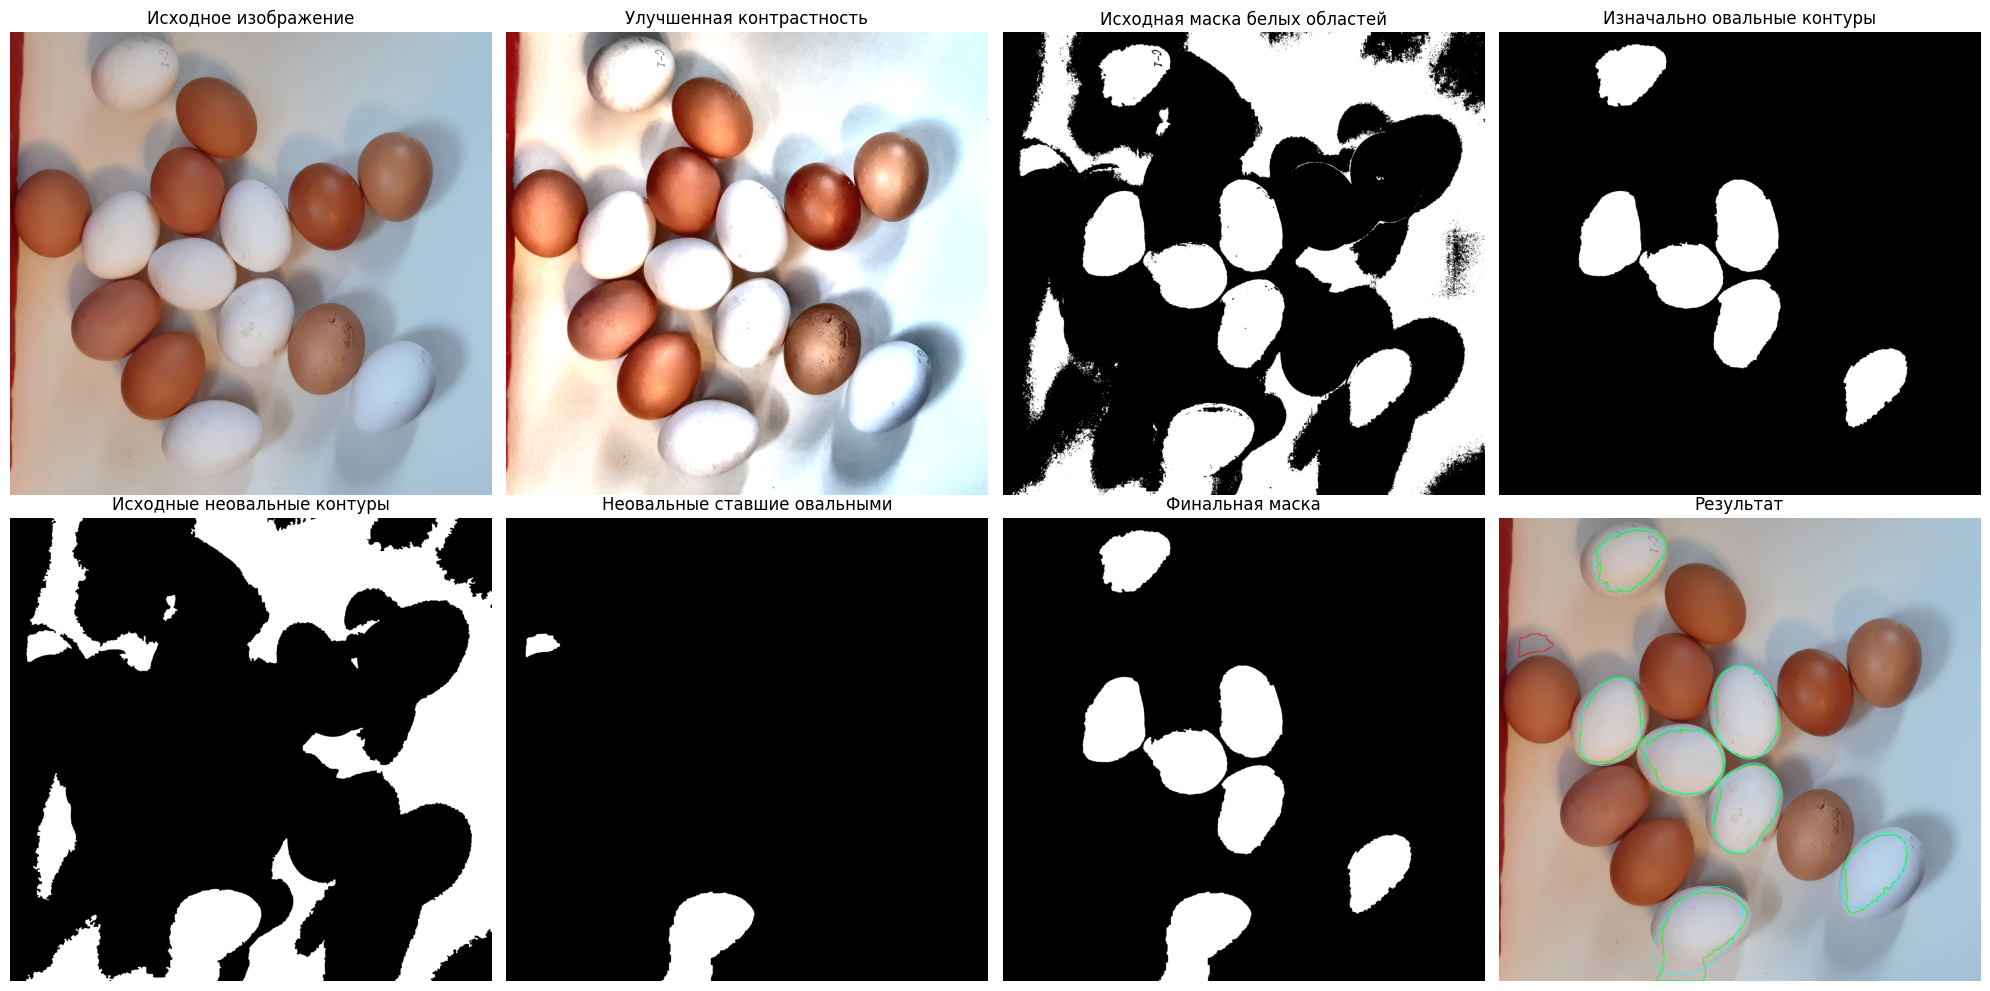


 Обработка коричневых яиц


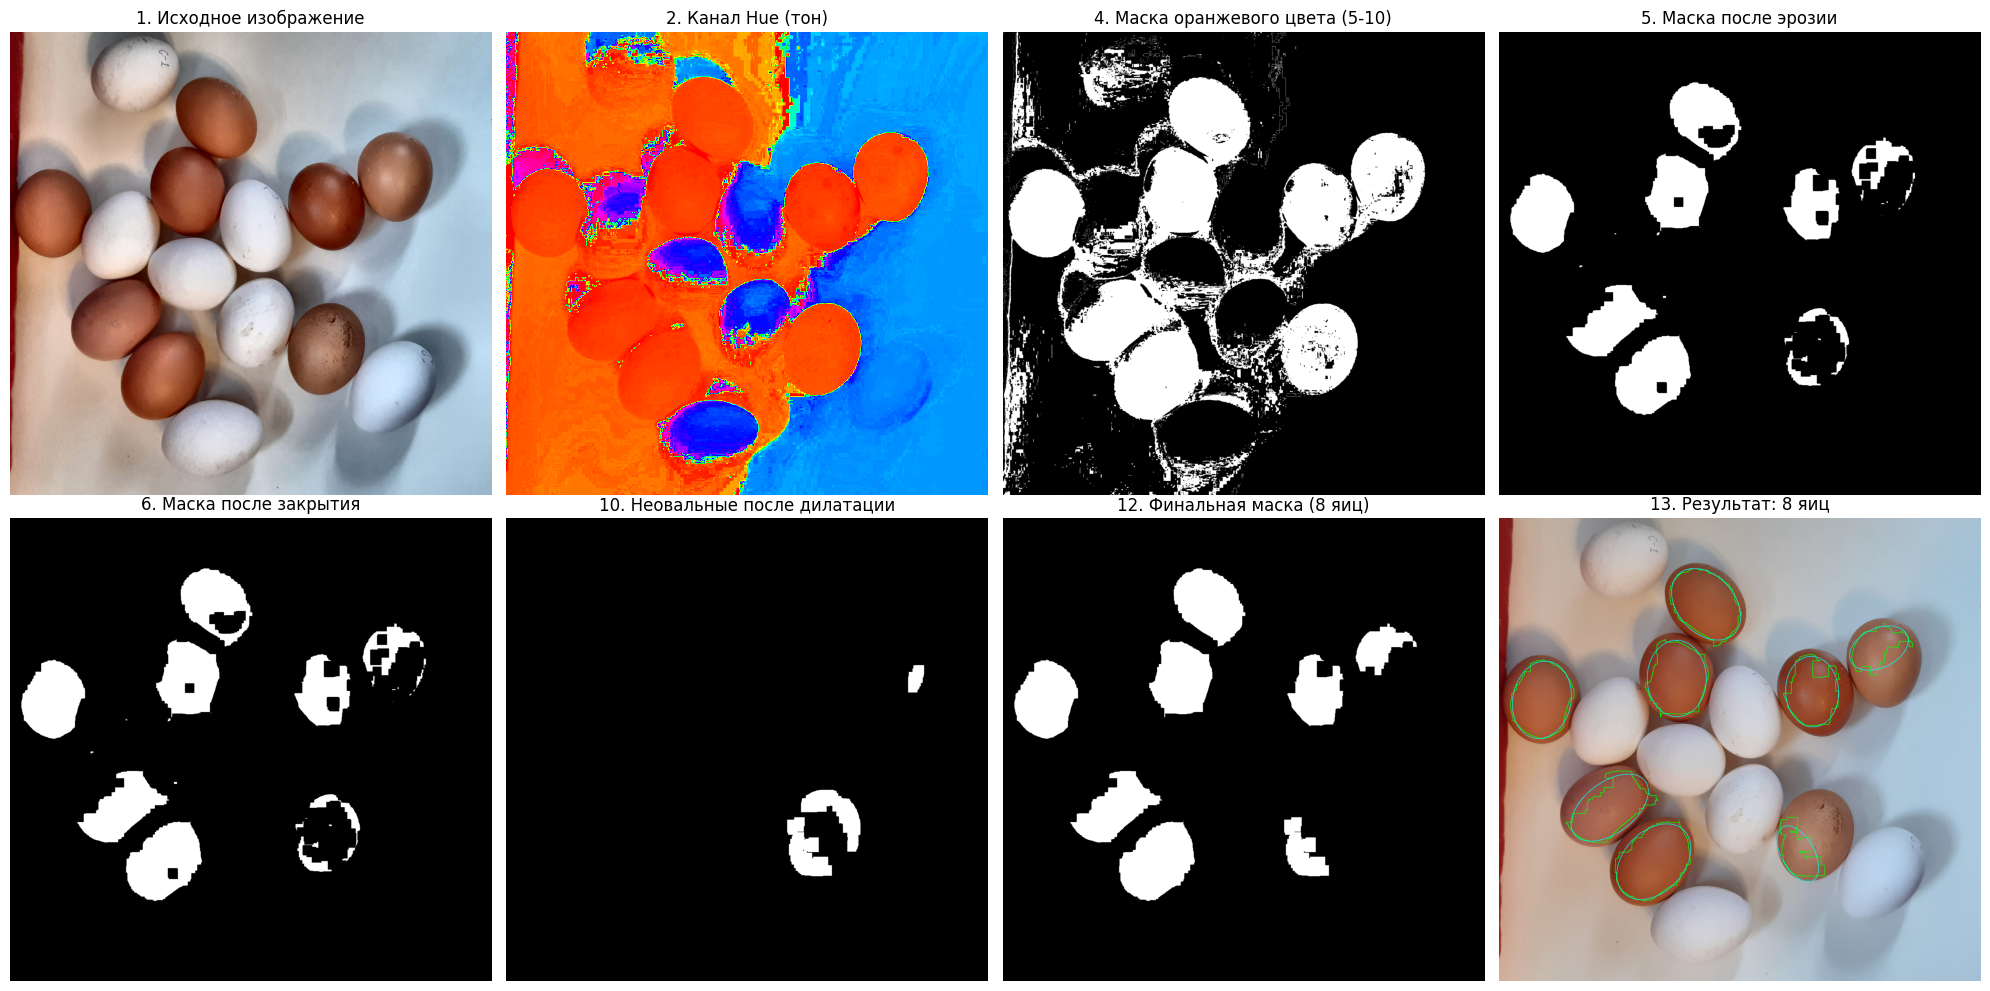


Белых яиц: 7
Коричневых яиц: 8
Суммарно обнаружено 15 яиц


In [4]:
print(f'Обработка белых яиц')
white = segment_eggs_white(image_path)
print(f'\n Обработка коричневых яиц')
brown = segment_eggs_brown(image_path)


print(f'\nБелых яиц: {white}')
print(f'Коричневых яиц: {brown}')
print(f'Суммарно обнаружено {white+brown} яиц')